# Q learning process made visible - the mountain car environment

### For whom this notebook is 

This notebook is for you if you are relatively new to Q learning / reinforcement learning and want to know, how Q learning works on a technical level. Therefore it would be helpful, if you already have some basic knowledge of 
* Reinforcement learning (basic principles, etc.)
* Q learning (Bell equation, etc.)     

If not, please have a look in [Wikipedia](https://en.wikipedia.org/wiki/Q-learning) or similar explanations first. The video https://www.youtube.com/watch?v=1XRahNzA5bE (especially the second part of the video) shows quite well, how Q learning works.     
By running this notebook you should understand a little bit better, what is going on **during** the Q learning process in the **Q table**, which is a **state action matrix** which learns to predict the "right actions" better and better.

### Overview
As in many educational notebooks, we are using one of the [OpenAI environments](http://gym.openai.com/): It's the [Mountain car environment](http://gym.openai.com/envs/MountainCar-v0/).   

This notebook shows, how Q learning teaches a car (with a weak engine) to drive up a mountain by getting the right momentum In order to best visualize what's going on in the Q table, I have choosen this environment because it has a 2-dimensional observation space, which can be shown as a 2-dimensional table. Have a look at the [GitHub code](https://github.com/openai/gym/wiki/MountainCar-v0) to know about the details of the observation and action space.

### Technical preconditions
Basically there is only one special technical precondition for running this notebook: `gym` has to be installed (see https://gym.openai.com/docs/#installation for the installation notes). 
Neither special AI frameworks (Tensorflow, Pytorch, etc.) nor GPUs are required.

In [22]:
import gym
import numpy as np

# Create the environment 
env = gym.make('MountainCar-v0')

# Set up the maximal number of steps a bit (for practical reasons)
env._max_episode_steps = 250

### State model

The state vector of the observation space gives us float values for the two state components:
* position
* velocity

But for Q learning we need **discrete states**. First things we have to do is to define a mapping from from float values to discrete **Q states**.

* The function `q_state_splits()` gets us the "split points", which we need to map floats to a predined number of discrete Q states
* The function `q_state()` maps a float state to a discrete Q state (by using the split points)

In [23]:
def q_state_splits(obs_low, obs_high, nr_states=(12, 12)):
    """Get two lists of split points to cut the observation space into pieces
    
    param:  obs_low:   lowest values in observation space
    param:  obs_high:  highest values in observation space
    param:  nr_states: number of states wanted 
    return: two arrays with split points, in order to cut the observation space into pieces
    """

    # length of single split segment
    length_0 = (obs_high[0] - obs_low[0])/nr_states[0]
    length_1 = (obs_high[1] - obs_low[1])/nr_states[1]
    
    # list of split points for the segments
    splits_0 = [obs_low[0] + ii * length_0 for ii in range(1, nr_states[0])]
    splits_1 = [obs_low[1] + ii * length_1 for ii in range(1, nr_states[1])]
    
    # arrays of split points
    return [np.array(splits_0), np.array(splits_1)]

def q_state(obs_state, splits):
    """Get discrete state out from float state
    
    param:  obs_state:   Float state from the observation space
    param:  splits:      Split points for the mapping to discrete states
    return: Discrete state 
    """

    # map the float values to discrete states
    state_0 = np.digitize(np.array([obs_state[0]]), splits[0])
    state_1 = np.digitize(np.array([obs_state[1]]), splits[1])
    
    # Discrete state
    return [state_0[0], state_1[0]]

# Get the split points for the float observation space (in order to get discrete states later)
state_splits = q_state_splits(env.observation_space.low, env.observation_space.high, nr_states=(12, 12))

### Q learning agent
The following class implements the Q learning agent. The core function is `action()`, which both updates the Q table and decides about the next action. As already mentioned the video https://www.youtube.com/watch?v=1XRahNzA5bE is very helpful to understand the following formula, which is at the core of the function `action()`:

`self.q_table[self.last_state + (self.last_action,)] += self.learning_rate * (reward + self.discount_rate * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])`

In [28]:
class QLearningAgent:
    """Q learning agent hosting the Q table"""

    def __init__(self, env, state_splits, learning_rate=0.02, discount_rate=0.99,
                 explore_rate=1.0, explore_decay_rate=0.995, min_explore_rate=.01, seed=1):
        """Initialize parameters and Q table
        
        param: env:                Mountain car environment
        param: state_splits:       Split structure for mapping float states to discrete states
        param: learning_rate:      Learning rate
        param: discount_rate:      Discount rate
        param: explore_rate:       Explore rate factor
        param: explore_decay_rate: Decrease factor of explore rate
        param: min_explore_rate:   Minimal explore rate
        param: seed:               Seed
        """
        
        # environment info
        self.env          = env
        self.state_splits = state_splits
        self.state_size   = tuple(len(splits) + 1 for splits in self.state_splits)  
        self.action_size  = self.env.action_space.n  
        self.seed         = np.random.seed(seed)
        
        # Q learning parameters
        self.learning_rate        = learning_rate  
        self.discount_rate        = discount_rate  
        self.initial_explore_rate = explore_rate
        self.explore_rate         = self.initial_explore_rate  
        self.explore_decay_rate   = explore_decay_rate 
        self.min_explore_rate     = min_explore_rate
        
        # initialized Q table
        self.q_table              = np.zeros([self.state_size[0], 
                                              self.state_size[1], 
                                              self.action_size])

    def discrete_state(self, obs_state):
        """Map float state from observation space to discrete state
        
        param:  obs_state: Float value of observation space
        return: Discrete state
        """
        
        # Discrete state
        return tuple(q_state(obs_state, self.state_splits))

    def reset_episode(self, obs_state):
        """Set initial variables (state and action) for a new episode
        
        param:  obs_state: Initial (reset) state from the observation environment
        return: Initial action decided upon
        """
        
        # Gradually decrease exploration rate - not lower than the minimum
        self.explore_rate *= self.explore_decay_rate
        self.explore_rate  = max(self.explore_rate, self.min_explore_rate)

        # Decide about initial action
        self.last_state  = self.discrete_state(obs_state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        
        return self.last_action
    
    def action(self, obs_state, reward, done):
        """Decide about the next action and update the q table
        
        param:  obs_state:  state from the environment
        param:  reward:     reward from the environment (-1 because of NOT reaching the top of the hill)
        param:  done:       done flag from the environment
        return: action
        """
        
        # get a discrete state
        state = self.discrete_state(obs_state)
        
        # This is the core formula of the Q learning (temporal difference learning)
        # The Q table entry for the last state is updated 
        self.q_table[self.last_state + (self.last_action,)] += self.learning_rate * \
        (reward + self.discount_rate * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])
        
        # exploration versus exploitation
        do_exploration = np.random.uniform(0, 1) < self.explore_rate
        if do_exploration:
            # Pick a random action
            action = np.random.randint(0, self.action_size)
        else:
            # Pick the best action from the Q table
            action = np.argmax(self.q_table[state])

        # switch over to next state and action
        self.last_state  = state
        self.last_action = action
        
        return action

# Create the Q learning agent    
q_agent = QLearningAgent(env, state_splits)

### Plotting of the Q table
The following method `plot_q_table()` prints out the Q table and associated information. We will use it intensively during training for plotting the interim states. Some explanations:
* The 2-dimensional observation space is shown as a matrix (e.g. 12 x 12)
* Each matrix cell contains action info. The shortcuts are as follows:
    * **.**  = action space not explored yet
    * **R>** = preferred action: Speed up to the right
    * **<L** = preferred action: Speed up to the left
    * **<>** = preferred action: No speed up        
* The colour of the cell shows the Q value of the preferred action
* The following episode information is shown in addition:
    * Number of the episode
    * Mean success rate of the last episodes (% of cars having reached the top of the hill)

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_q_table(q_table, i_episode=None, success_rate='?'):
    """Visualize the Q state matrix 
    
    param: q_table:      Q table 
    param: i_episode:    Number of the episode
    param: success_rate: Success rate (%) of the current episode
    """
    
    # highest Q value - for each state
    q_max_vals = np.max(q_table, axis=2)     
    # any action defined yet? - for each state
    q_actions_defined = np.sum(q_table, axis=2) != 0
    # best action - for each state
    q_actions = np.argmax(q_table, axis=2)   
    
    fig, ax = plt.subplots(figsize=(5, 5))
    cax     = ax.imshow(q_max_vals, cmap='Wistia'); 
    fig.colorbar(cax)
    
    # add "action description text" for each cell (state) in the diagram
    for x in range(q_table.shape[0]):
        for y in range(q_table.shape[1]):
            
            # textual shortcuts for preferred actions of a special state
            if not q_actions_defined[x, y]:
                text  ='.'     # no preferred action defined yet
                color = 'red'
            elif q_actions[x, y] == 2:
                text  = 'R>'   # preferred action = speed up to the right
                color = 'black'
            elif q_actions[x, y] == 0:
                text  = '<L'   # preferred action = speed up to the left
                color = 'white'
            else:
                text  = '><'   # preferred action = no speed change
                color = 'white'
            ax.text(x, y, text, color=color, 
                    horizontalalignment='center', verticalalignment='center', weight='bold')
    
    ax.grid(False)
    
    # add titles and labels to diagram
    if i_episode == None:
        ax.set_title("Q-table, size: {}".format(q_table.shape))
    else:
        ax.set_title("Q-table episode {} with {}% success".format(i_episode, success_rate))
        
    ax.set_xlabel('left                 position                right')
    ax.set_ylabel('moving right ... standing ... moving left')

### Training 
The following function `train()` runs the training. Interim states of the Q table are printed out. Basically you should see the following effects:
* The exploration space starts in the middle (bottom of the valley) and gets wider and wider
* The agent learns to speed up to the right, when the car is already driving in the right direction. That's why the lower half of the matrix is getting filled with **R>** - except the the turning points were the car rolls back in the valley. That's why the **R>** cells are mostly limited by **><** cells or **<L** cells to the right or to the left.

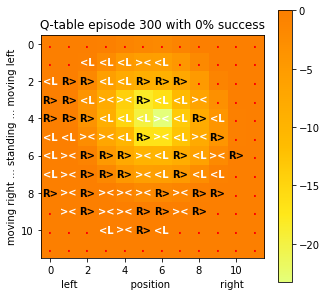

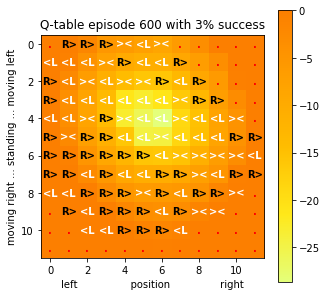

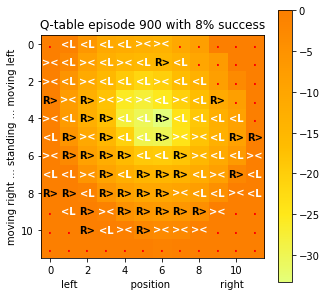

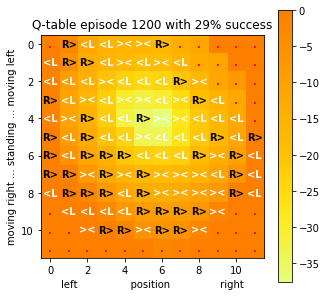

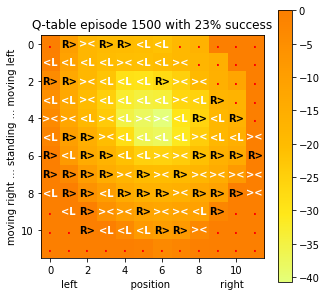

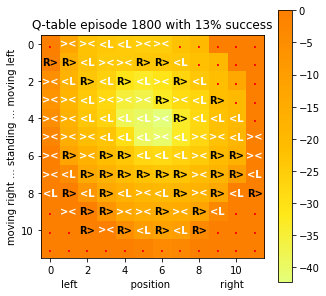

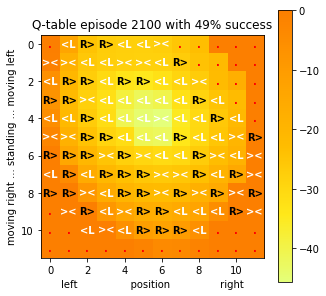

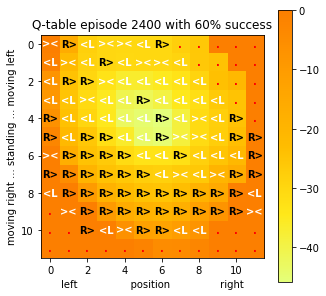

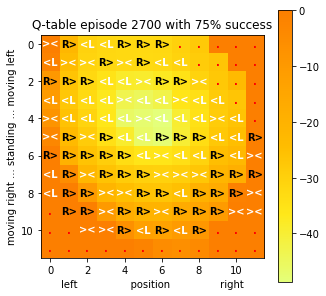

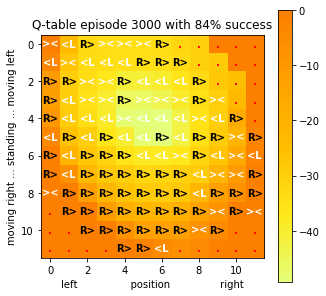

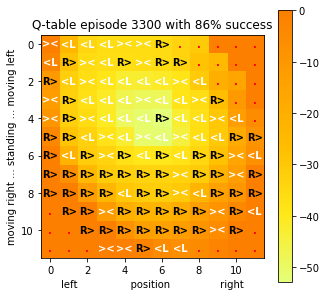

In [30]:
def train(agent, env, num_episodes=3300):
    """Run training and return scores.

    param:  agent:        Q learning agent 
    param:  env:          Mountain car environment
    param:  num_episodes: Number of episodes
    return: list of scores (= nr of steps until success or limit reached)
    """
    
    # print out rhythm
    show_every = 300

    scores = []    
    for i_episode in range(1, num_episodes+1):
        
        # Initialize episode
        state        = env.reset()
        action       = agent.reset_episode(state)
        total_reward = 0
        done         = False

        # Run episode step by step ...
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.action(state, reward, done)

        # Add to list of scores
        scores.append(total_reward)
        
        # show current state of the Q state matrix
        if (i_episode % show_every) == 0:
            last_scores = scores[-show_every:]
            success_rate = 100 - int(100 * last_scores.count(- env._max_episode_steps) / show_every)             
            plot_q_table(q_agent.q_table, i_episode=i_episode, success_rate=success_rate)
            plt.show()

    return scores

# run the training
scores = train(q_agent, env, num_episodes=3300)

The following function `plot_scores()` shows the training progress.

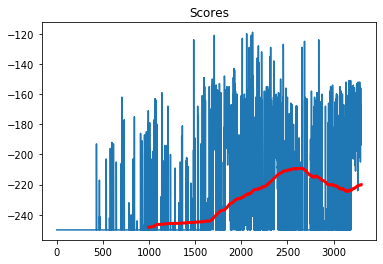

In [27]:
import pandas as pd

def plot_scores(scores, smoothing=1000):
    """Plot scores and mean scores curve
    
    param: scores:    score statistics, which we got as the result of the training
    param: smoothing: smoothing factor for additional smoothed curve 
    """
    
    plt.plot(scores)
    plt.title("Scores");
    mean = pd.Series(scores).rolling(smoothing).mean()
    plt.plot(mean, linewidth=3, color='red');

plot_scores(scores)

The following code opens the environment windows and runs one episode so you can watch how the system behaves. Feel free to run as many examples as you want.

In [ ]:
# reset episode
state  = env.reset()
action = q_agent.reset_episode(state)
done   = False
steps  = 0

# run a whole episode
while not done:
    state, reward, done, _ = env.step(action)
    action = q_agent.action(state, reward, done)
    env.render()
    steps += 1

# print final result    
if steps == env._max_episode_steps:
    print('Car did not get it in the maximal time ({} steps)-:'.format(env._max_episode_steps))
else:
    print('Big success in {} steps :-)'.format(steps))   

Please note, that we are still in training mode - but with a exploration_rate meanwhile being quite low:

In [ ]:
q_agent.explore_rate

After having watched "enough" examples best close the environment window:

In [ ]:
env.close()